In [33]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [34]:
# Fetch LFW dataset with minimum faces per person = 40
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=0.4)
# Extracting data and target labels
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
# df = np.genfromtxt('./lfw_people.csv',delimiter=',')
# X = df[:, :-1]
# y = df[:, -1]
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

# Print dataset statistics
print("Number of samples: %d" % n_samples)
print("Number of features: %d" % n_features)
print("Number of classes: %d" % n_classes)

Number of samples: 1706
Number of features: 1850
Number of classes: 16


## Building a PCA class

In [35]:
class PCA:
  def __init__(self,n_components=None):
    # To initialize a PCA object

    # Total number of reduced features in projected data
    self.n_components = n_components
    self.eigenvalues = None
    self.eigenvectors=None
    self.means=None

  def fit(self,X):
    # To fit the model and finding principal components given an array X.
    if self.n_components==None:
      self.n_components=X.shape[0]
    self.means = np.mean(X,axis=0)
    X_mean = X-self.means
    cov_matrix = (X_mean.T @ X_mean)/X_mean.shape[0]
    cov_matrix = (cov_matrix + cov_matrix.T)/2
    self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)
    self.eigenvalues = np.abs(np.real(self.eigenvalues))
    self.eigenvectors = np.real(self.eigenvectors)

    # (v) Sort eigenvectors based on eigenvalues
    # print(eigenvalues[eigenvalues<0])
    sorted_indices = np.argsort(self.eigenvalues)[::-1]
    self.eigenvalues = self.eigenvalues[sorted_indices]
    self.eigenvectors = self.eigenvectors[:, sorted_indices]
    self.eigenvectors = self.eigenvectors/np.sqrt((np.sum(self.eigenvectors*self.eigenvectors, axis=0)))
    return X @ self.eigenvectors[:,:self.n_components]

  def fit_transform(self,X):
    # returns the given array after projected it along principal components
    return X @ self.eigenvectors[:,:self.n_components]


  def explained_variance(self):
    # returns first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]
  def explained_variance_ratio(self):
    # returns ratio of variance captured by first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]/np.sum(self.eigenvalues)

  def components(self):
    # returns principal components
    return self.eigenvectors[:,:self.n_components]

  def get_eigenvalues(self):
    # returns all eigen values
    return self.eigenvalues
  def get_eigenvectors(self):
    # returns all eigenvectors
    return self.eigenvectors

### PCA implementation

In [36]:
# To perform splitting of data into train and test sets with ratio 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
num_components=192   # To reduce the data into 200 features.
# To apply PCA on train data and get principal components.
pca = PCA(n_components=num_components)
X_projected = pca.fit(X_train)
X_test_projected = pca.fit_transform(X_test)
principal_components = pca.components()
# Convert principal components back to eigen faces.
eigenfaces = (principal_components.T).reshape((principal_components.shape[1],50,37))

# Reconstruct the original data from the extracted features.
X_reconstructed = (X_projected @ (principal_components.T))

### Explained Variance ratio

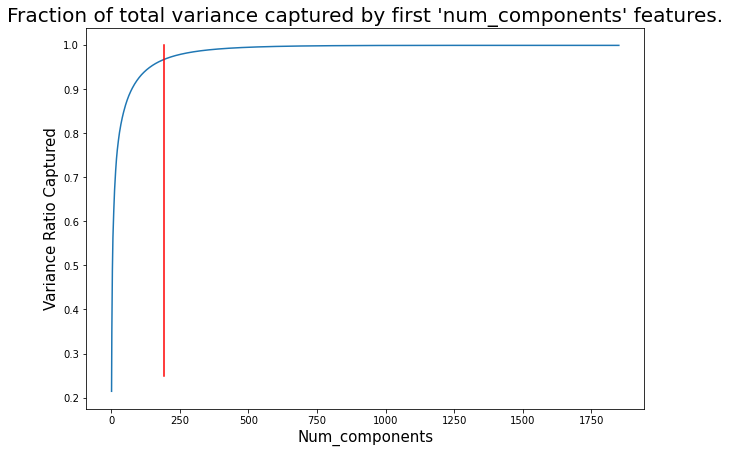

In [37]:
# To plot the graph of total variance captured by first 'num_components' eigen vectors.
x = np.arange(1,1851,1)
y = np.cumsum(pca.get_eigenvalues())/np.sum(pca.get_eigenvalues())
plt.figure(figsize=(10,7))
plt.plot(x,y)

x = [num_components,num_components]
y = [0.25,1]
plt.plot(x,y,'r')
plt.title("Fraction of total variance captured by first 'num_components' features.",size=20)
plt.xlabel("Num_components",size=15)
plt.ylabel("Variance Ratio Captured",size=15)
plt.show()

### Eigen Faces

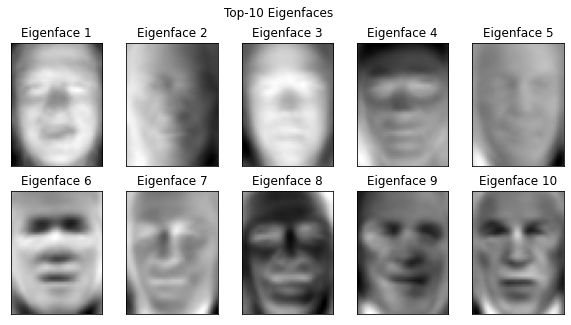

In [38]:
# To plot the first 10 eigenfaces
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.title(f"Eigenface {i + 1}")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Top-10 Eigenfaces")
plt.show()

### Reconstructed face data

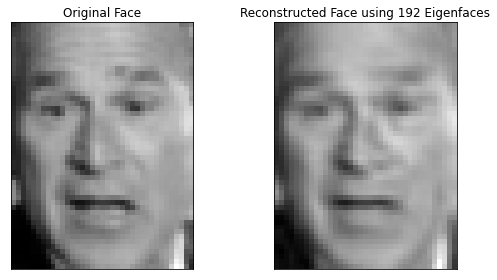

In [39]:
og_face0 = X_train[0].reshape((50,37))
reconstructed_face0 = X_reconstructed[0].reshape((50,37))
# Plot the original and reconstructed faces
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(og_face0, cmap='gray')  # Reshape to original shape before plotting
plt.title('Original Face')
plt.xticks(())
plt.yticks(())

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_face0, cmap='gray')
plt.title(f'Reconstructed Face using {num_components} Eigenfaces')
plt.xticks(())
plt.yticks(())

plt.tight_layout()
plt.show()

In [40]:
class LDAclass:
    def __init__(self, n_components):
        self.n_components = n_components
    def fit_transform(self,X_train,Y_train):
        #X_train = X_train.T
        overall_mean = np.mean(X_train, axis=0)

        Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
        Sb = np.zeros((X_train.shape[1], X_train.shape[1]))
        for i in np.unique(Y_train):
            class_indices = np.where(Y_train == i)[0]
            class_data = X_train[class_indices,:]
            class_mean = np.mean(class_data, axis=0)
            class_mean_diff = class_data - class_mean
            Sw += class_mean_diff.T @ class_mean_diff
        
        overall_mean_diff = X_train-overall_mean
        Sb = overall_mean_diff.T @ overall_mean_diff
        Sb-=Sw

        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw) @ Sb)
        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)
        eigenvectors = eigenvectors/np.sqrt(np.sum(eigenvectors*eigenvectors))
        #eigenvectors = eigenvectors/(np.sum(eigenvectors*eigenvectors,axis=0))

        sorted_indices = np.argsort(np.abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
# Only the first 6 eigenvalues have significance. Remaining values are close to zero compared to first six eigenvalues.
        
        self.principal_components = eigenvectors[:, :self.n_components]
        X_projected = X_train @ self.principal_components
        print(eigenvalues[:10])
        return X_projected
    
    def transform(self,X):
        return X @ self.principal_components
    
    def fischerfaces(self):
        return ((self.principal_components.T).reshape((self.principal_components.shape[1],16,12)))

[3.04520837 2.13175133 1.743553   1.48826803 1.19375848 1.01416136
 0.90009349 0.72023851 0.65139758 0.45343078]


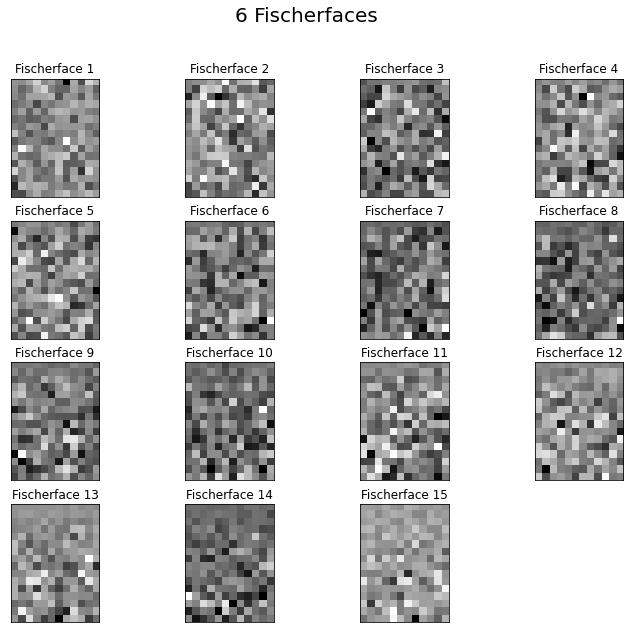

In [41]:
X_projected = X_train @ principal_components
X_test_projected = X_test @ principal_components
n_components=len(np.unique(Y_train)) - 1
lda = LDAclass(n_components = n_components)
X_projected = lda.fit_transform(X_projected, Y_train)
X_test_projected = lda.transform(X_test_projected)
fischerfaces = lda.fischerfaces()
plt.figure(figsize=(12,10))
for i in range(n_components):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fischerfaces[i], cmap='gray')
    plt.title(f"Fischerface {i + 1}")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("6 Fischerfaces",size = 20)
plt.show()

## Building the Decision Tree Classifier Class

In [42]:
class Node:
  # stores left child, right child, condition(attribute+value) for splitting, class label
  def __init__(self,label):
      self.left = None
      self.right = None
      self.attribute = None
      self.value = None
      self.label = label

In [43]:
class ClassificationTree:
    
    def __init__(self,max_depth=None,min_samples_split=2, min_samples_leaf=1, min_impurity_decrease=0.0,min_impurity=0,criterion="gini",random_state=0,max_features=None):
        """
        Parameters:
        - max_depth: int or None, optional (default=None)
            The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure
            or until all leaves contain less than min_samples_split samples.
        - min_samples_split: int, optional (default=2)
            The minimum number of samples required to split an internal node.
        - min_samples_leaf: int, optional (default=1)
            The minimum number of samples required to be at a leaf node.
        - min_impurity_decrease: float, optional (default=0.0)
            A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
        - min_impurity: float, optional (default=0)
            The minimum impurity required for a split to happen.
        - criterion: {"gini", "entropy"}, optional (default="gini")
            The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.
        - random_state: int, RandomState instance or None, optional (default=0)
            Controls the randomness of the estimator. If the value is an integer, it is used as the random seed.
        - max_features: {int, float, "sqrt", "log2", None}, optional (default=None)
            The number of features to consider when looking for the best split:
            - If int, then consider max_features features at each split.
            - If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
            - If "sqrt", then max_features=sqrt(n_features).
            - If "log2", then max_features=log2(n_features).
            - If None, then max_features=n_features
        """
        self.max_depth=max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity = min_impurity
        self.criterion="gini"
        self.random_state=random_state
        self.max_features=max_features

    def Entropy(self,df):
        # Calculate the gini impurity/entropy of a dataset.
        if self.criterion=="gini":
            im = 1
            labels = df[:,-1]
            size = labels.shape[0]
            for i in np.unique(labels):
                count = np.sum([labels==i])
                im-=(count/size)*(count/size)
            return im
        en = 0
        labels = df[:,-1]
        size = labels.shape[0]
        for i in np.unique(labels):
            ratio = np.sum([labels==i])/size
            en-=ratio*np.log2(ratio)*np.log(2)
        return en

    def label(self,df):
        # Determine the label of a dataset.
        labels = df[:,-1]
        maxcount=0
        label=0
        for i in np.unique(labels):
            count = np.sum(labels==i)
            if count>maxcount:
                maxcount=count
                label = i
        return label

    def fit(self,df,labels):
        # Fit and train the decision tree classifier.
        if isinstance(df, pd.DataFrame):
            self.df = np.array(df)
        if isinstance(labels,pd.DataFrame):
            labels=np.array(labels)
        if self.max_features==None:
            self.featurevector = np.ones(df.shape[1])
        else:
            features = np.arange(0,df.shape[1])
            np.random.seed(self.random_state)
            np.random.shuffle(features)
            if self.max_features=='sqrt':
                features = features[:int(np.sqrt(df.shape[1]))]
            elif self.max_features=='log2':
                features = features[:int(np.log2(df.shape[1]))]
            elif isinstance(self.max_features,int):
                features = features[:self.max_features]
            elif isinstance(self.max_features,float):
                features = features[:int(self.max_features*df.shape[1])]
            self.featurevector = np.zeros(df.shape[1])
            self.featurevector[features]=1

        self.df = np.column_stack([df,labels])
        self.root = self.train(self.df,0)

    def train(self,df,depth):
        # To train the decision tree recursively.
        # This function returns the pointer of a tree node
        if self.max_depth!=None and depth==self.max_depth:
            return None
        tempnode = Node(self.label(df))
        e = self.Entropy(df)
        if df.shape[0]<self.min_samples_split or e<self.min_impurity:
#             print(tempnode.attribute,tempnode.value,e,None,df.shape[0],"leaf")
            return tempnode
        maxgain=0
        # Now we find the best entropy gain by searching all coulmns.
        for col in range(df.shape[1]-1):
            if (self.featurevector[col]):
                df = df[df[:, col].argsort()]
                means = np.unique(df[:,col])
                means = (means[:-1]+means[1:])/2
                for mean in means:
                    ldf = df[df[:,col]<mean]
                    rdf = df[df[:,col]>=mean]
                    gain = e-(ldf.shape[0]*self.Entropy(ldf)+rdf.shape[0]*self.Entropy(rdf))/df.shape[0]
                    if gain>maxgain and ldf.shape[0]>=self.min_samples_leaf and rdf.shape[0]>=self.min_samples_leaf:
                        maxgain = gain
                        tempnode.value=mean
                        tempnode.attribute=col
        if maxgain>0 and maxgain>=self.min_impurity_decrease:
            tempnode.left = self.train(df[df[:,tempnode.attribute]<tempnode.value],depth+1)
            tempnode.right = self.train(df[df[:,tempnode.attribute]>=tempnode.value],depth+1)
#         print(tempnode.attribute,tempnode.value,self.Entropy(df),maxgain,df.shape[0],end = " ")
#         if tempnode.left==None:
#             print("leaf")
#         else:
#             print()
        return tempnode

    def Infer(self,X):
        # To make predictions using the trained decision tree.
        tempnode = self.root
        while tempnode!=None and tempnode.left!=None:
            if (X[tempnode.attribute]<tempnode.value):
                tempnode = tempnode.left
            else:
                tempnode = tempnode.right
        # Now we have reached a leaf node, hencee return its label.
        return tempnode.label

### Decision Tree Model Evaluation

Testing data Accuracy: 0.5818713450292398


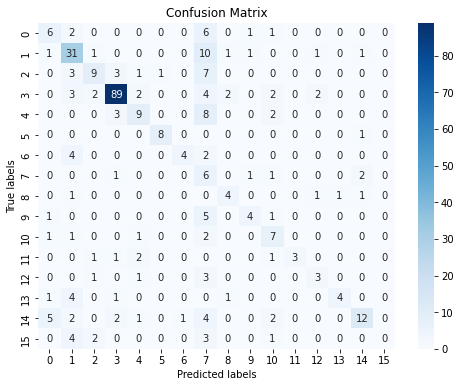

In [77]:
# ct1 = DecisionTreeClassifier(max_depth=6)
ct1 = ClassificationTree(max_depth=7)
ct1.fit(X_projected,Y_train)
Y_pred = []
for row in X_test_projected:
    Y_pred.append(ct1.Infer(row))
Y_pred = np.array(Y_pred)
# Y_pred = ct1.predict(X_test_projected)
accuracy = accuracy_score(Y_test, Y_pred)
print("Testing data Accuracy:", accuracy)
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Building the Random Forest Clasiifier

In [45]:
class RandomForestClassify:
    def __init__(self,n_estimators=100,random_state=0,bootstrap=True,max_features='sqrt',max_samples=None,max_depth=None,min_samples_split=1,min_samples_leaf=1,min_impurity=0,min_impurity_decrease=0,criterion='gini'):
        """
        Initialize a RandomForestClassify object with specified hyperparameters.

        Parameters:
        - n_estimators: int, optional (default=100)
            The number of trees in the forest.
        - random_state: int, RandomState instance or None, optional (default=0)
            Controls the randomness of the estimator. If the value is an integer, it is used as the random seed.
        - bootstrap: bool, optional (default=True)
            Whether bootstrap samples are used when building trees.
        - max_features: {int, float, "sqrt", "log2", None}, optional (default='sqrt')
            The number of features to consider when looking for the best split:
            - If int, then consider max_features features at each split.
            - If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
            - If "sqrt", then max_features=sqrt(n_features).
            - If "log2", then max_features=log2(n_features).
            - If None, then max_features=n_features.
        - max_samples: int or float, optional (default=None)
            If bootstrap is True, the number of samples to draw from X to train each base estimator.
            - If None (default), then draw X.shape[0] samples.
            - If int, then draw max_samples samples.
            - If float, then draw max_samples * X.shape[0] samples.
        """
        self.n_estimators=n_estimators
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.max_features = max_features
        self.max_samples=max_samples
        # This self.classifiers stores the list of all decision tree classifier objects.
        self.classifiers = []
        np.random.seed(self.random_state)
        rstates = np.random.randint(0,2147483647,size=n_estimators)
        for i in range(n_estimators):
            self.classifiers.append(ClassificationTree(random_state=rstates[i],max_features=max_features,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,min_impurity=min_impurity,min_impurity_decrease=min_impurity_decrease,criterion=criterion))
        self.classifiers=np.array(self.classifiers)
        
    def fit(self,X,Y):
        
        # To fit the random forest classifier.
        if not self.bootstrap:
            self.max_samples=None
        elif self.max_samples==None:
            self.max_samples=X.shape[0]
        elif isinstance(self.max_samples,float):
            self.max_samples = min(int(self.max_samples*X.shape[0]),X.shape[0])
        elif isinstance(self.max_samples,int):
            self.max_samples = min(int(self.max_samples),X.shape[0])
        
        for i in range(self.n_estimators):
            if not self.bootstrap:
                self.classifiers[i].fit(X,Y)
            else:
                np.random.seed(self.classifiers[i].random_state)
                indices = np.random.randint(0,X.shape[0],size = self.max_samples)
                self.classifiers[i].fit(X[indices,:],Y[indices])
            
    def Infer(self,x):
        # To make predictions using the trained multiple decision tree classifiers.
        dic = {}
        for i in range(self.n_estimators):
            output = self.classifiers[i].Infer(x)
            if output in dic:
                dic[output]+=1
            else:
                dic[output]=1
        #print(dic)
        bestlabel = list(dic.keys())[0]
        for i in list(dic.keys()):
            if dic[i]>dic[bestlabel]:
                bestlabel=i
        return bestlabel
    def predict(self,X):
        # To make predictions using the trained multiple decision tree classifiers.
        pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            pred[i] = self.Infer(X[i])
        return pred

### Grid Search - Hyperparameter Tuning

In [95]:
random_forest = RandomForestClassifier()
param_grid = {
    'n_estimators': [100],
    'max_depth': [11,12,13],
    'min_samples_leaf': [2,10],
    'min_samples_split':[2,15],
    'min_impurity_decrease': [0,0.0005],
    'random_state': [0]
}
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_projected, Y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 12, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 0}


### Random Forest Classifier Evaluation

Testing data Accuracy: 0.7894736842105263


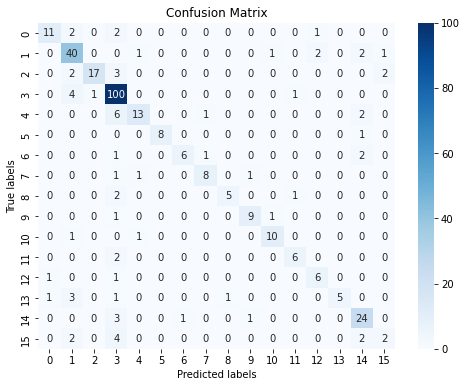

In [96]:
# Using the best hyperparameters
random_forest = RandomForestClassifier(n_estimators=100,max_depth=12,min_impurity_decrease=0.0005,random_state=0)
random_forest.fit(X_projected,Y_train)
Y_pred = random_forest.predict(X_test_projected)
accuracy = accuracy_score(Y_test, Y_pred)
print("Testing data Accuracy:", accuracy)
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()